# Knowledge Graph Construction
##### Web Based Systems 2024, [FCSE](https://finki.ukim.mk/)

The focus of this exercise is going to be on information extraction from short text documents (specifically stock news headlines) in order to generate a knowledge graph from the extracted information.

We will explore a SOTA Transformer model for extracting triples from unstructured data, namely [REBEL](https://arxiv.org/abs/2306.09802) (Relation Extraction By End-to-end Language generation).
To use the model we need to install HuggingFace transformers.

Later we will also perform a step for entity resolution (the process of working out whether multiple records are referencing the same real-world thing) to further normalize the knowledge graph. For this we will use the library sentence-transformers which features models trained on tasks such as creating embeddings for text data.

You can use this framework to compute sentence / text embeddings for more than 100 languages. These embeddings can then be compared e.g. with cosine-similarity to find sentences with a similar meaning

## Install and Import the Required Libraries

In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx import connected_components
import matplotlib.pyplot as plt
import random

## Download the dataset

In [2]:
!gdown 1sb4yvNrRUKDqCMGg692UsKtI3YmPvxo-

Downloading...
From: https://drive.google.com/uc?id=1sb4yvNrRUKDqCMGg692UsKtI3YmPvxo-
To: /content/Stock_headlines.csv
100% 9.43M/9.43M [00:00<00:00, 26.8MB/s]


For our use-case we will use the multilingual version of the REBEL model (mREBEL) available on the [HuggingFace model hub](https://huggingface.co/Babelscape/mrebel-large).

It can be used as a standalone multulingual Relation Extraction system, or as a pretrained system to be tuned on multilingual Relation Extraction datasets.

## Model specific functions

Here we set the device to 'cuda' if we have an available GPU on the machine where we are running the code, if not we set the model to be run on CPU.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We will follow the instructions defined in the model card in order to use the model properly for relation-extraction.

The function ```extract_triplets_typed``` is provided by the creators of the model. It's a utility function that helps us parse the generated triples from the model.

In [4]:
def extract_triplets_typed(text):
    triplets = []
    relation = ''
    text = text.strip()
    current = 'x'
    subject, relation, object_, object_type, subject_type = '','','','',''

    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").replace("tp_XX", "").replace("__en__", "").split():
        if token == "<triplet>" or token == "<relation>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'head_type': subject_type, 'type': relation.strip(),'tail': object_.strip(), 'tail_type': object_type})
                relation = ''
            subject = ''
        elif token.startswith("<") and token.endswith(">"):
            if current == 't' or current == 'o':
                current = 's'
                if relation != '':
                    triplets.append({'head': subject.strip(), 'head_type': subject_type, 'type': relation.strip(),'tail': object_.strip(), 'tail_type': object_type})
                object_ = ''
                subject_type = token[1:-1]
            else:
                current = 'o'
                object_type = token[1:-1]
                relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '' and object_type != '' and subject_type != '':
        triplets.append({'head': subject.strip(), 'head_type': subject_type, 'type': relation.strip(),'tail': object_.strip(), 'tail_type': object_type})
    return triplets

We will use a beam search of 3, and generate 3 triplets per input text. We will set the maximum length of the generated sequence to be 256 tokens, and we will not penalize the model for generating lengthy sequences. This is done by setting the following parameters:

```
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 3,
```

In [5]:
gen_kwargs = {
  "max_length": 256,
  "length_penalty": 0,
  "num_beams": 3,
  "num_return_sequences": 3,
}

In [7]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/mrebel-large", src_lang="en_XX", tgt_lang="tp_XX")
# Here we set English ("en_XX") as source language. To change the source language swap the first token of the input for your desired language or change to supported language. For catalan ("ca_XX") or greek ("el_EL") (not included in mBART pretraining) you need a workaround:
# tokenizer._src_lang = "ca_XX"
# tokenizer.cur_lang_code_id = tokenizer.convert_tokens_to_ids("ca_XX")
# tokenizer.set_src_lang_special_tokens("ca_XX")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/mrebel-large")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

Set the model to device (CPU or GPU)

In [8]:
model.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250071, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250071, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=

In [6]:
def tokenize_and_extract_relations(batch):
  # Tokenizer text
  model_inputs = tokenizer(batch, max_length=256, padding=True, truncation=True, return_tensors = 'pt')  # tokenize the input and return pytorch tensors

  # Generate

  # The model input contains the 'input_ids' (the ids of the inpu tokens)
  # and 'attention_mask' a mask that shows the model which tokens are important and which are not.
  generated_tokens = model.generate(
    model_inputs["input_ids"].to(model.device),
    attention_mask=model_inputs["attention_mask"].to(model.device),
    decoder_start_token_id = tokenizer.convert_tokens_to_ids("tp_XX"),  # this decodes the tokens to ids using triples as the target 'language'
    **gen_kwargs,
  )

  # Extract text
  decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

  # Extract triplets using the utility function (the generation returns 3 triples)
  result = []
  for idx, sentence in enumerate(decoded_preds):
    result.extend(extract_triplets_typed(sentence))
  return result

## Read the dataset

In [9]:
data = pd.read_csv("/content/Stock_headlines.csv")

In [10]:
data.head()

Unnamed: 0  Sentiment                                           Sentence
0           0          0  According to Gran , the company has no plans t...
1           1          1  For the last quarter of 2010 , Componenta 's n...
2           2          1  In the third quarter of 2010 , net sales incre...
3           3          1  Operating profit rose to EUR 13.1 mn from EUR ...
4           4          1  Operating profit totalled EUR 21.1 mn , up fro...

We will create a knowledge graph using the first 1000 headlines in the dataset (because of execution time restrictions)

In [11]:
sentences = list(data['Sentence'].values)

In [13]:
sentences[:10]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ',
 "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ",
 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn ',
 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales ',
 'Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales ',
 'Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn ',
 "Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004

In [14]:
kg = []

In [15]:
batch_size = 32

In [16]:
for i in tqdm(range(0, 1000, batch_size)):
  kg.extend(tokenize_and_extract_relations(sentences[i:i+batch_size]))

100%|██████████| 32/32 [02:04<00:00,  3.89s/it]


The provided results contains the columns 'head', 'head_type', 'type', 'tail', 'tail_type'. We will convert the result to a dictionary and drop the duplicates of the triples 'head' 'type' 'tail', since the model might find the same head as having multiple types (example concept and location).

In [17]:
kg_relations = pd.DataFrame(kg)

In [18]:
kg_relations = kg_relations.dropna()  # drop possible null values

In [19]:
kg_relations = kg_relations.drop_duplicates(subset=['head', 'type', 'tail'], keep='first')

In [20]:
kg_relations

head head_type           type  \
0                              Gran       org        country   
1                            Russia       loc  item operated   
2                            Russia       loc     subsidiary   
3                              2010      time  point in time   
6             third quarter of 2010      time  point in time   
...                             ...       ...            ...   
3495                   ahlstrom.com   concept    instance of   
3496                        Teleste       org     subsidiary   
3497  Video and Broadband Solutions       org       owned by   
3498                        Teleste       org       industry   
3500   financial statement for 2008   concept  point in time   

                               tail tail_type  
0                            Russia       loc  
1                              Gran       org  
2                              Gran       org  
3                              2010      date  
6                              2010      date  
...                             ...       ...  
3495                        website   concept  
3496  Video and Broadband Solutions       org  
3497                        Teleste       org  
3498  Video and Broadband Solutions   concept  
3500                           2008      date  

[2290 rows x 5 columns]

Save the dataset

In [21]:
kg_relations.to_csv(f'/content/kg_stock_headlines.csv', index=False)

## Entity Resolution

We will use a small model from the sentence-transformers library to create embeddings for each head entity and each tail entity. The embeddings represent semantic similarites between the two texts.

We will check the cosine similarity between all entities using a brute-force approach and try to map two entities to the same concept if their cosine similarity is greater than 0.95. This is defined in the function ```resolve_entities_by_text_embeddings```

In [22]:
def resolve_entities_by_text_embeddings(entities, embeddings):
  entity_mapping = {}
  for i in range(len(entities)):
    e1 = entities[i]
    for j in range(i + 1, len(entities)):
      e2 = entities[j]

      if e1 == e2:
        continue

      similarity = util.cos_sim(embeddings[i], embeddings[j])

      if similarity > 0.95:
        entity_mapping[entities[j]] = entities[i]
        entities[j] = entities[i]
        embeddings[j] = embeddings[i]

  return entity_mapping

In [23]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Add the model to GPU for faster execution

In [24]:
embedding_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [25]:
entities = list(set(kg_relations['head'].values + kg_relations['tail'].values))  # we convert to set first to remove duplicates

In [26]:
len(entities)

1984

In [27]:
entity_embeddings = embedding_model.encode(entities)

The function will perform entity resolution on the head and tail texts (subjects and objects in the relation)




In [28]:
entities_resolution_dict = resolve_entities_by_text_embeddings(entities, entity_embeddings)

In [29]:
entities_resolution_dict

{'CapMan PlcHeikki Westerlund': 'CapManHeikki Westerlund',
 'cocktail glassstainless steel': 'cocktail glassesstainless steel',
 'N78Nokia': 'N79Nokia',
 'N95Nokia': 'N79Nokia',
 'N96Nokia': 'N79Nokia',
 'N77Nokia': 'N79Nokia',
 'EUR2005': 'eur2007',
 'Alma Media CorporationEUR 45,0315VII': 'Alma Media CorporationEUR 45,0311920',
 'Nordic ExchangeHelsinki': 'Nordic exchangeHelsinki',
 'euro735 millioneuro742.2': 'euro735 millioneuro742.2 million',
 'eurforecast': 'eurforecasts',
 'September 2009September 2008': 'September 2009September 2009',
 'BasWareshares': 'Baswareshares',
 'Financial Statementsfinancial statement': 'Financial Statementsfinancial statements',
 '20072007': '20072006',
 'Elcoteq SENasdaq OMX Helsinki Ltd.': 'ElcoteqNasdaq OMX Helsinki Ltd.',
 'strapping tapePetcore': 'strapping tapePET',
 'non-recurring expensesexpenses': 'non-recurring expensesexpense',
 'non-recurring expenseexpense': 'non-recurring expensesexpense',
 "Neste oil 's2007": 'Neste oil2007',
 'Avalon M

Replace the name of the entities using the mapping dictionary

In [30]:
kg_relations = kg_relations.replace({"head": entities_resolution_dict, "tail": entities_resolution_dict})

In [31]:
len(kg_relations)

2290

We are going to drop duplicate triples since now we may end up with them again after the entity resolution step.

In [32]:
kg_relations = kg_relations.drop_duplicates(subset=['head', 'type', 'tail'], keep='first')

In [33]:
kg_relations = kg_relations.dropna()

In [34]:
len(kg_relations)

2290

Save the normalized triples.

In [35]:
kg_relations.to_csv(f'/content/kg_stock_headlines_normalized.csv', index=False)

We are going to create a NetworkX graph to visualize the extracted information

In [36]:
G = nx.Graph()
for _, row in kg_relations.iterrows():
  G.add_edge(row['head'], row['tail'], label=row['type'])

In [37]:
components = [c for c in connected_components(G)]

In [38]:
len(components)

308

We create a subgraph using the largest connected component

In [40]:
graph_to_draw = G.subgraph(components[0])

In [41]:
graph_to_draw

In [42]:
len(components[0])

1019

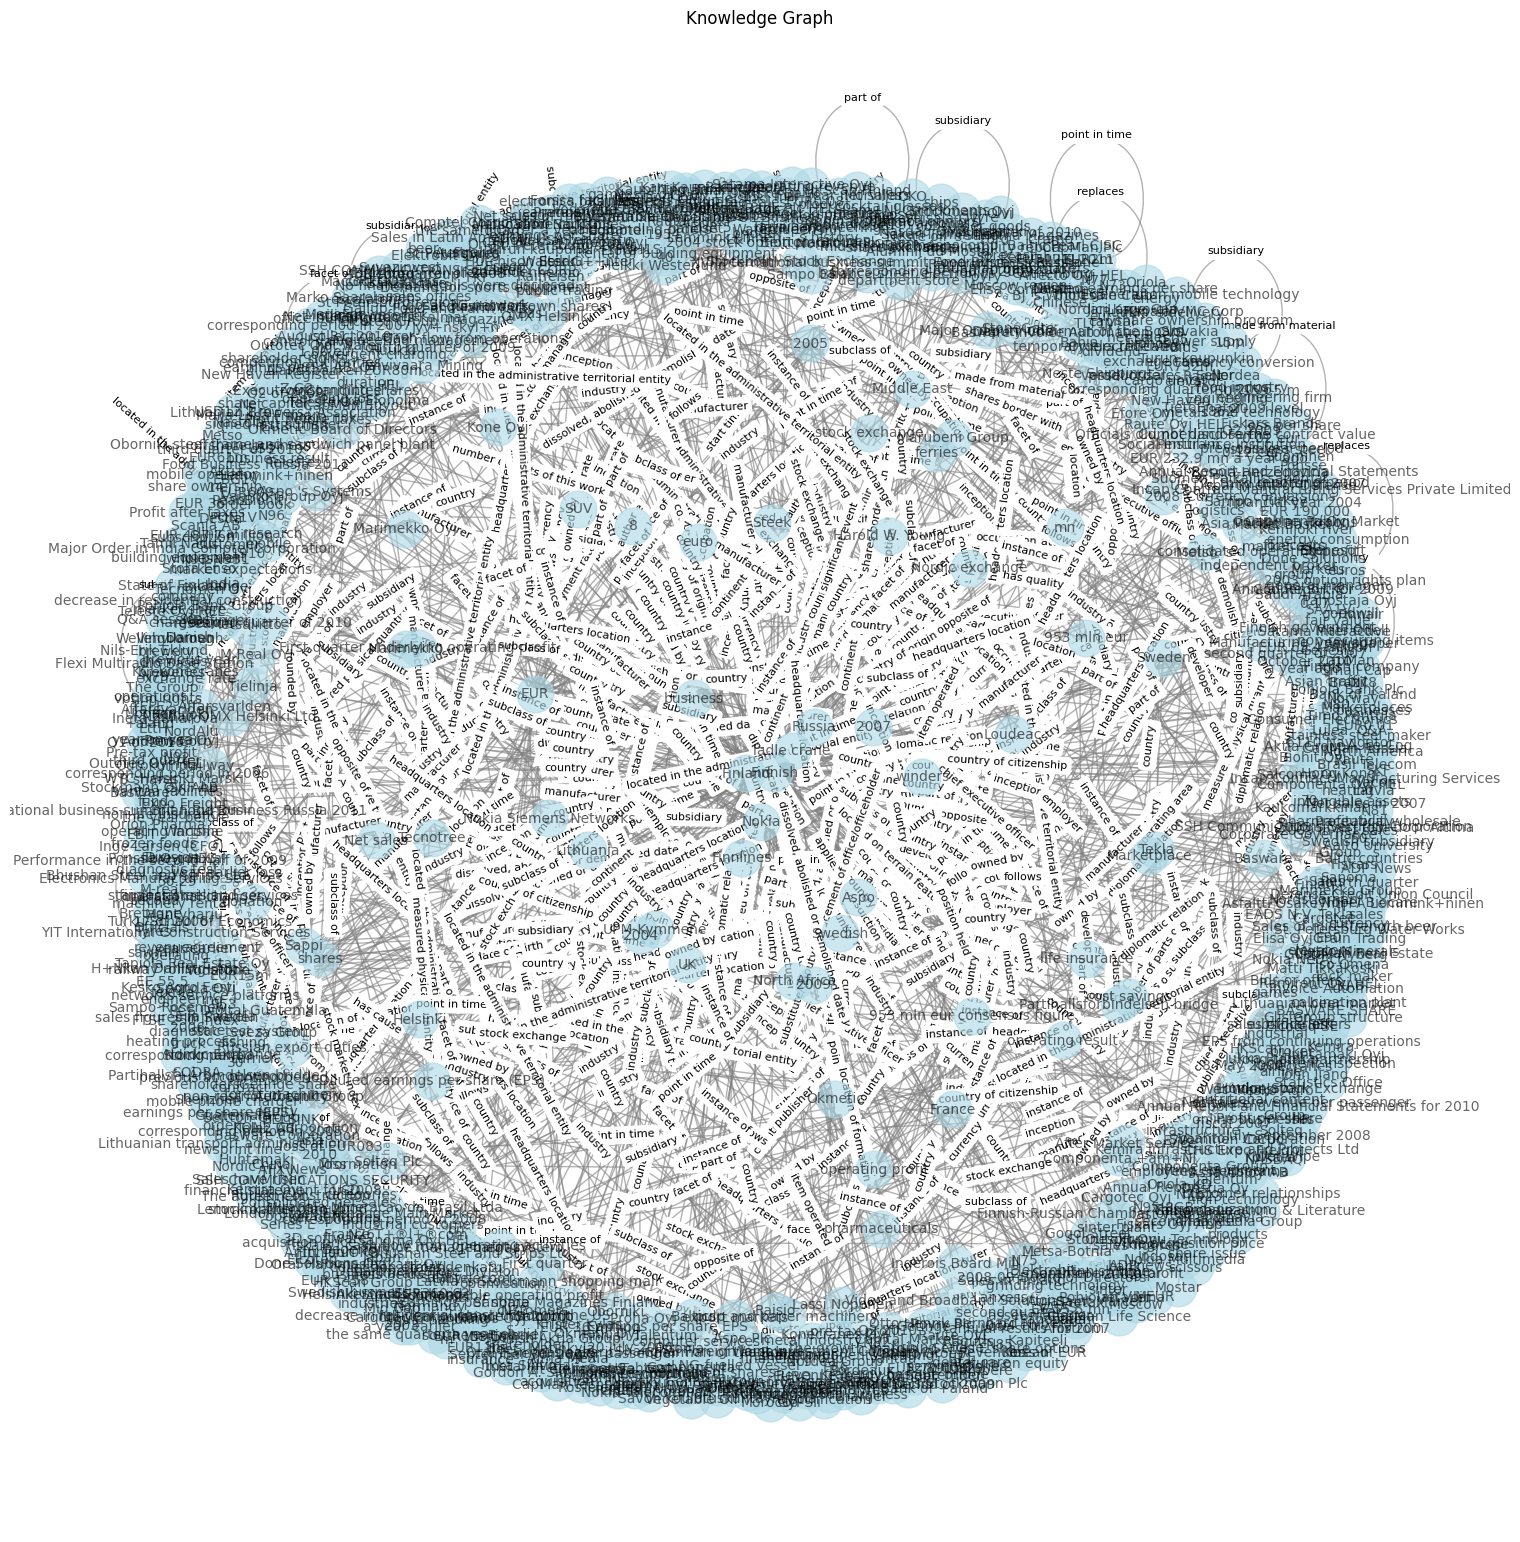

In [43]:
pos = nx.spring_layout(graph_to_draw, seed=42, k=0.9)
labels = nx.get_edge_attributes(graph_to_draw, 'label')
plt.figure(figsize=(15, 15))
nx.draw(graph_to_draw, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(graph_to_draw, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

In [44]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Ratio edges to nodes: {round(num_edges / num_nodes, 2)}')

Number of nodes: 1923
Number of edges: 1844
Ratio edges to nodes: 0.96


# Entity and Relation types

Let's take a look at the types of entities and relations that we have extracted from the headlines.

In [45]:
kg_relations['head_type'].unique()

array(['org', 'loc', 'time', 'concept', 'eve', 'media', 'per', 'misc', ''],
      dtype=object)

In [46]:
kg_relations['tail_type'].unique()

array(['loc', 'org', 'date', 'concept', 'eve', 'media', 'misc', 'per',
       'num', 'time'], dtype=object)

In [47]:
kg_relations['type'].unique()

array(['country', 'item operated', 'subsidiary', 'point in time',
       'inception', 'manufacturer', 'industry', 'subclass of', 'facet of',
       'opposite of', 'instance of', 'owned by', 'follows', 'currency',
       'replaces', 'part of', 'measured physical quantity', 'start time',
       'publisher', 'author', 'educated at', 'country of citizenship',
       'country of origin', 'headquarters location', 'brand',
       'diplomatic relation', 'studies', 'end time',
       'chief executive officer', 'employer', 'director / manager',
       'unemployment rate', 'elevation above sea level',
       'number of parts of this work', 'duration', 'developer',
       'stock exchange', 'occupation', 'position held', 'model item',
       'operating area', 'business division', 'stock market index',
       'location', 'located in the administrative territorial entity',
       'founded by', 'use', 'residence', 'chairperson',
       'dissolved, abolished or demolished date',
       'date of officia

# Neo4j Graph Database

A graph database stores nodes and relationships instead of tables, or documents.

 Your data is stored without restricting it to a pre-defined model, allowing a very flexible way of thinking about and using it.

Neo4j is an open-source, NoSQL, native graph database that provides an ACID-compliant transactional backend for your applications that has been publicly available since 2007.

Neo4j is offered as a managed service via AuraDB. But you can also run Neo4j yourself with either Community Edition or Enterprise Edition.

We are going to create a free, managed instance of AuraDB to store our graph.

First we are going to install ```neo4j```.





In [ ]:
from neo4j import GraphDatabase

In [ ]:
# Replace these with your actual Neo4j connection details

URL = "neo4j+s://<db_id>.databases.neo4j.io"  # You can find the connection string once you create the instance
username = "<username>"
password = "<password>"
AUTH = (username, password)

In [ ]:
def insert_data_into_neo4j(df, driver):
  with driver.session() as session:
    for index, row in df.iterrows():
      query = f"""
      MERGE (h:{row['head_type']} {{name: $head}})
      MERGE (t:{row['tail_type']} {{name: $tail}})
      MERGE (h)-[:{row['type'].replace(' ', '_')}]->(t)
      """

      try:
        session.run(query, head=row['head'], tail=row['tail'])  # can have errors because of punctuation in relaitons
      except:
        continue

In [ ]:
with GraphDatabase.driver(URL, auth=AUTH) as driver:
  driver.verify_connectivity()  # verify the connectivity
  insert_data_into_neo4j(kg_relations, driver)  # insert the data

## Example subgraph for the relation 'diplomatic relation'

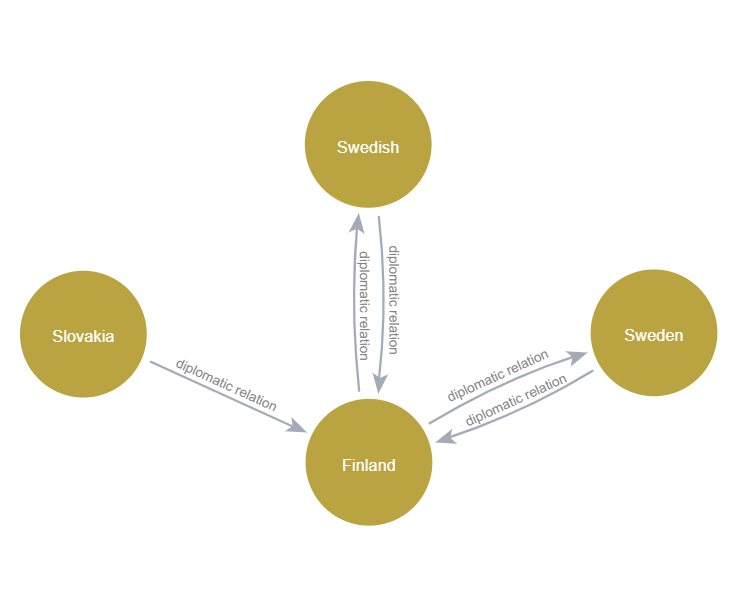**